In [17]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [18]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [19]:
print(tf.__version__)

2.11.0


In [20]:
tf.random.set_seed(42)
np.random.seed(42)

In [21]:
train_df = pd.read_csv('data/train.csv', index_col=0)
val_df = pd.read_csv('data/val.csv', index_col=0)
test_df = pd.read_csv('data/test.csv', index_col=0)
print(train_df.shape, val_df.shape, test_df.shape)

(2151, 7) (614, 7) (308, 7)


In [22]:
train_df.head()

,Open,High,Low,Close,Volume,CionScore,Coin_timestamp
0,0.010909,0.009038,0.011130,0.010638,0.000274,0.394260,0.000000
1,0.010731,0.008742,0.010713,0.010195,0.000214,0.597569,0.000465
2,0.010274,0.008349,0.009911,0.009390,0.000337,0.440592,0.000930
3,0.009482,0.007685,0.008210,0.007804,0.000557,0.440592,0.001395
4,0.007877,0.006544,0.006264,0.007371,0.001044,0.440592,0.001860


In [23]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='UpDown', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [24]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

In [25]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

## CNN 

### Multi-step model 

In [26]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 7
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

multi_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=1, label_columns=['Close'])

In [27]:
# Values obtained from chapter 15

ms_mae_val = []
ms_mae_test = []

In [28]:
train_df.head()

,Open,High,Low,Close,Volume,CionScore,Coin_timestamp
0,0.010909,0.009038,0.011130,0.010638,0.000274,0.394260,0.000000
1,0.010731,0.008742,0.010713,0.010195,0.000214,0.597569,0.000465
2,0.010274,0.008349,0.009911,0.009390,0.000337,0.440592,0.000930
3,0.009482,0.007685,0.008210,0.007804,0.000557,0.440592,0.001395
4,0.007877,0.006544,0.006264,0.007371,0.001044,0.440592,0.001860


In [29]:
ms_cnn_model = Sequential([
    # Conv1D(64, kernel_size=(KERNEL_WIDTH)),
    # Conv1D(64, kernel_size=(KERNEL_WIDTH)),
    # LSTM(32, return_sequences=True), 
    LSTM(64, return_sequences=True), 
        
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(ms_cnn_model, multi_window)

ms_val_performance = {}
ms_performance = {}

ms_val_performance['CNN'] = ms_cnn_model.evaluate(multi_window.val)
ms_performance['CNN'] = ms_cnn_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50


ValueError: in user code:

    File "c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1024, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1082, in compute_loss
        return self.compiled_loss(
    File "c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\losses.py", line 284, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\losses.py", line 1500, in mean_squared_error
        return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)

    ValueError: Dimensions must be equal, but are 9 and 7 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](sequential/dense/BiasAdd, IteratorGetNext:1)' with input shapes: [?,9,1], [?,7,1].


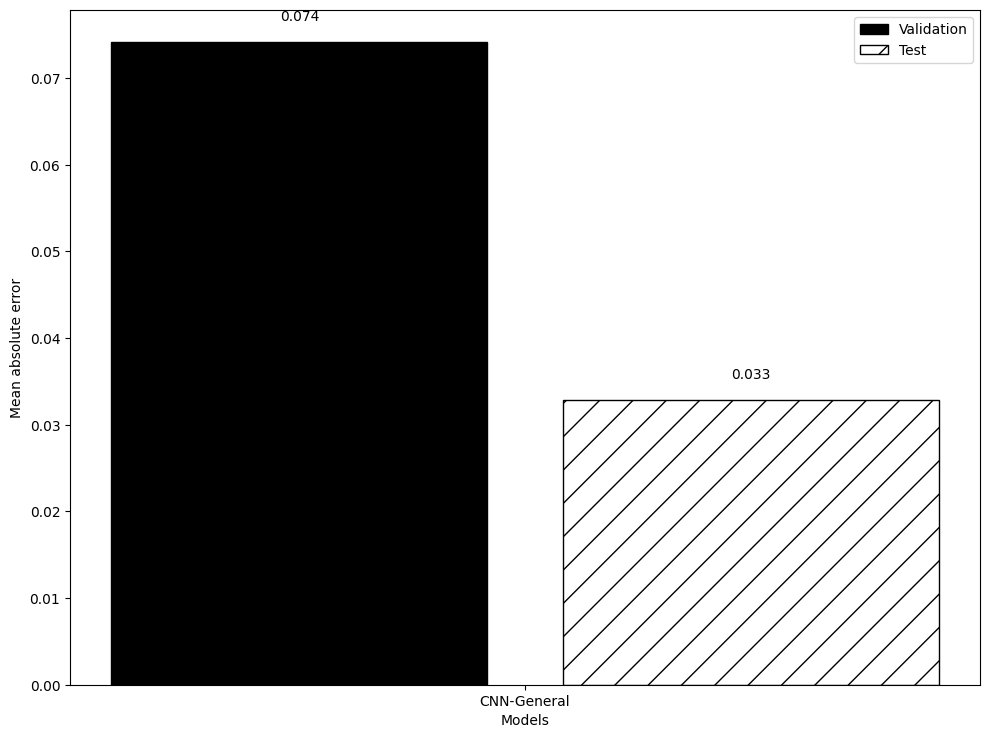

In [81]:
ms_mae_val.extend([v[1] for v in ms_val_performance.values()])
ms_mae_test.extend([v[1] for v in ms_performance.values()])

x = np.arange(1)

labels = ['CNN-General']

fig, ax = plt.subplots()
ax.bar(x - 0.15, ms_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, ms_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(ms_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(ms_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

plt.savefig('figures/CH16_F07_peixeiro.png', dpi=300)